In [1]:
import os
import argparse
import datetime
import time


import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [2]:
def get_loader(args):
    if args.dataset == 'mnist':
        # Transforms for train
        train_transform = transforms.Compose([transforms.Resize([args.image_size, args.image_size]),
                                            transforms.RandomCrop(args.image_size, padding=2),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.5], [0.5])])
        train = datasets.MNIST(os.path.join(args.data_path, args.dataset), train=True, download=True, transform=train_transform)

        # Transforms for test
        test_transform = transforms.Compose([transforms.Resize([args.image_size, args.image_size]), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
        test = datasets.MNIST(os.path.join(args.data_path, args.dataset), train=False, download=True, transform=test_transform)


    elif args.dataset == 'fmnist':
        train_transform = transforms.Compose([transforms.Resize([args.image_size, args.image_size]),
                                            transforms.RandomCrop(args.image_size, padding=2),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.5], [0.5])])
        train = datasets.FashionMNIST(os.path.join(args.data_path, args.dataset), train=True, download=True, transform=train_transform)

        test_transform = transforms.Compose([transforms.Resize([args.image_size, args.image_size]), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
        test = datasets.FashionMNIST(os.path.join(args.data_path, args.dataset), train=False, download=True, transform=test_transform)


    elif args.dataset == 'svhn':
        train_transform = transforms.Compose([transforms.Resize([args.image_size, args.image_size]),
                                            transforms.RandomCrop(args.image_size, padding=2),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.4376821, 0.4437697, 0.47280442], [0.19803012, 0.20101562, 0.19703614])])
        train = datasets.SVHN(os.path.join(args.data_path, args.dataset), split='train', download=True, transform=train_transform)

        test_transform = transforms.Compose([transforms.Resize([args.image_size, args.image_size]), transforms.ToTensor(), transforms.Normalize([0.4376821, 0.4437697, 0.47280442], [0.19803012, 0.20101562, 0.19703614])])
        test = datasets.SVHN(os.path.join(args.data_path, args.dataset), split='test', download=True, transform=test_transform)

    elif args.dataset == 'cifar10':
        train_transform = transforms.Compose([transforms.Resize([args.image_size, args.image_size]),
                                            transforms.RandomCrop(args.image_size, padding=4),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandAugment(),  # RandAugment augmentation for strong regularization
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])])
        train = datasets.CIFAR10(os.path.join(args.data_path, args.dataset), train=True, download=True, transform=train_transform)

        test_transform = transforms.Compose([transforms.Resize([args.image_size, args.image_size]), transforms.ToTensor(), transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])])
        test = datasets.CIFAR10(os.path.join(args.data_path, args.dataset), train=False, download=True, transform=test_transform)

    else:
        print("Unknown dataset")
        exit(0)

    # Define dataloaders
    train_loader = torch.utils.data.DataLoader(dataset=train,
                                                 batch_size=args.batch_size,
                                                 shuffle=True,
                                                 num_workers=args.n_workers,
                                                 drop_last=True)

    test_loader = torch.utils.data.DataLoader(dataset=test,
                                                batch_size=args.batch_size,
                                                shuffle=False,
                                                num_workers=args.n_workers,
                                                drop_last=False)

    return train_loader, test_loader

In [3]:
# B -> Batch Size
# C -> Number of Input Channels
# IH -> Image Height
# IW -> Image Width
# P -> Patch Size
# E -> Embedding Dimension
# S -> Sequence Length = IH/P * IW/P
# Q -> Query Sequence length (same as S for self-attention)
# K -> Key Sequence length (same as S for self-attention)
# V -> Value Sequence length (same as S for self-attention)
# H -> Number of heads
# HE -> Head Embedding Dimension = E/H


class EmbedLayer(nn.Module):
    def __init__(self, n_channels, embed_dim, image_size, patch_size, dropout=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, embed_dim, kernel_size=patch_size, stride=patch_size)  # Pixel Encoding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)  # Cls Token
        self.pos_embedding = nn.Parameter(torch.zeros(1, (image_size // patch_size) ** 2 + 1, embed_dim), requires_grad=True)  # Positional Embedding
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv1(x)  # B C IH IW -> B E IH/P IW/P (Embedding the patches)
        x = x.reshape([x.shape[0], x.shape[1], -1])  # B E IH/P IW/P -> B E S (Flattening the patches)
        x = x.transpose(1, 2)  # B E S -> B S E
        x = torch.cat((torch.repeat_interleave(self.cls_token, x.shape[0], 0), x), dim=1)  # Adding classification token at the start of every sequence
        x = x + self.pos_embedding  # Adding positional embedding

        x = self.dropout(x)
        return x


class SelfAttention(nn.Module):
    def __init__(self, embed_dim, n_attention_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_attention_heads = n_attention_heads
        self.head_embed_dim = embed_dim // n_attention_heads

        self.queries = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads) # Queries projection
        self.keys = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads)    # Keys projection
        self.values = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads)  # Values projection

        self.out_projection = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, x):
        b, s, e = x.shape

        xq = self.queries(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)  # B, Q, E -> B, Q, H, HE
        xq = xq.transpose(1, 2)  # B, Q, H, HE -> B, H, Q, HE
        xk = self.keys(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)  # B, K, E -> B, K, H, HE
        xk = xk.transpose(1, 2)  # B, K, H, HE -> B, H, K, HE
        xv = self.values(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)  # B, V, E -> B, V, H, HE
        xv = xv.transpose(1, 2)  # B, V, H, HE -> B, H, V, HE

        # Compute Attention presoftmax values
        xk = xk.transpose(-1, -2)  # B, H, K, HE -> B, H, HE, K
        x_attention = torch.matmul(xq, xk)  # B, H, Q, HE  *  B, H, HE, K -> B, H, Q, K

        # Scale presoftmax values for stability
        x_attention /= float(self.head_embed_dim) ** 0.5

        # Compute Attention Matrix
        x_attention = torch.softmax(x_attention, dim=-1)

        # Compute Attention Values
        x = torch.matmul(x_attention, xv)  # B, H, Q, K * B, H, V, HE -> B, H, Q, HE

        # Format the output
        x = x.transpose(1, 2)  # B, H, Q, HE -> B, Q, H, HE
        x = x.reshape(b, s, e)  # B, Q, H, HE -> B, Q, E

        x = self.out_projection(x)  # B, Q, E -> B, Q, E
        return x


class Encoder(nn.Module):
    def __init__(self, embed_dim, n_attention_heads, forward_mul, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = SelfAttention(embed_dim, n_attention_heads)
        self.dropout1 = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_mul)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_mul, embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout1(self.attention(self.norm1(x))) # Skip connections
        x = x + self.dropout2(self.fc2(self.activation(self.fc1(self.norm2(x)))))  # Skip connections
        return x


class Classifier(nn.Module):
    def __init__(self, embed_dim, n_classes):
        super().__init__()
        # New architectures skip fc1 and activations and directly apply fc2.
        self.fc1 = nn.Linear(embed_dim, embed_dim)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        x = x[:, 0, :]  # Get CLS token
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x


class VisionTransformer(nn.Module):
    def __init__(self, n_channels, embed_dim, n_layers, n_attention_heads, forward_mul, image_size, patch_size, n_classes, dropout=0.1):
        super().__init__()
        self.embedding = EmbedLayer(n_channels, embed_dim, image_size, patch_size, dropout=dropout)
        self.encoder = nn.ModuleList([Encoder(embed_dim, n_attention_heads, forward_mul, dropout=dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(embed_dim) # Final normalization layer after the last block
        self.classifier = Classifier(embed_dim, n_classes)


        self.apply(vit_init_weights) # Weight initalization

    def forward(self, x):
        x = self.embedding(x)
        for block in self.encoder:
            x = block(x)
        x = self.norm(x)
        x = self.classifier(x)
        return x


def vit_init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

    elif isinstance(m, EmbedLayer):
        nn.init.trunc_normal_(m.cls_token, mean=0.0, std=0.02)
        nn.init.trunc_normal_(m.pos_embedding, mean=0.0, std=0.02)

In [25]:
class Solver(object):
	def __init__(self, args):
		self.args = args

		# Get data loaders
		self.train_loader, self.test_loader = get_loader(args)

		# Create object of the Vision Transformer
		self.model = VisionTransformer(n_channels=self.args.n_channels, embed_dim=self.args.embed_dim,
										n_layers=self.args.n_layers, n_attention_heads=self.args.n_attention_heads,
										forward_mul=self.args.forward_mul, image_size=self.args.image_size,
										patch_size=self.args.patch_size, n_classes=self.args.n_classes, dropout=self.args.dropout)

		# Push to GPU
		if self.args.is_cuda:
			print("Using GPU")
			self.model = self.model.cuda()
		else:
			print("Cuda not available.")

		# Display Vision Transformer
		print('--------Network--------')
		print(self.model)

		# Option to load pretrained model
		if args.load_model:
			print("Using pretrained model")
			self.model.load_state_dict(torch.load(os.path.join(self.args.model_path, 'ViT_model.pt')))

		# Training loss function
		self.loss_fn = nn.CrossEntropyLoss()

		# Arrays to record training progression
		self.train_losses = []
		self.test_losses = []
		self.train_accuracies = []
		self.test_accuracies = []

	def test_dataset(self, loader):
		# Set Vision Transformer to evaluation mode
		self.model.eval()

		# Arrays to record all labels and logits
		all_labels = []
		all_logits = []

		# Testing loop
		for (x, y) in loader:
			if self.args.is_cuda:
				x = x.cuda()

			# Avoid capturing gradients in evaluation time for faster speed
			with torch.no_grad():
				logits = self.model(x)

			all_labels.append(y)
			all_logits.append(logits.cpu())

		# Convert all captured variables to torch
		all_labels = torch.cat(all_labels)
		all_logits = torch.cat(all_logits)
		all_pred = all_logits.max(1)[1]

		# Compute loss, accuracy and confusion matrix
		loss = self.loss_fn(all_logits, all_labels).item()
		acc = accuracy_score(y_true=all_labels, y_pred=all_pred)
		cm = confusion_matrix(y_true=all_labels, y_pred=all_pred, labels=range(self.args.n_classes))

		return acc, cm, loss

	def test(self, train=True):
		if train:
			# Test using train loader
			acc, cm, loss = self.test_dataset(self.train_loader)
			print(f"Train acc: {acc:.2%}\tTrain loss: {loss:.4f}\nTrain Confusion Matrix:")
			print(cm)

		# Test using test loader
		acc, cm, loss = self.test_dataset(self.test_loader)
		print(f"Test acc: {acc:.2%}\tTest loss: {loss:.4f}\nTrain Confusion Matrix:")
		print(cm)

		return acc, loss

	def train(self):
		iters_per_epoch = len(self.train_loader)

		# Define optimizer for training the model
		optimizer = optim.AdamW(self.model.parameters(), lr=self.args.lr, weight_decay=1e-3)

		# scheduler for linear warmup of lr and then cosine decay
		linear_warmup = optim.lr_scheduler.LinearLR(optimizer, start_factor=1/self.args.warmup_epochs, end_factor=1.0, total_iters=self.args.warmup_epochs-1, last_epoch=-1, verbose=True)
		cos_decay = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=self.args.epochs-self.args.warmup_epochs, eta_min=1e-5, verbose=True)

		# Variable to capture best test accuracy
		best_acc = 0

		# Training loop
		for epoch in range(self.args.epochs):

			# Set model to training mode
			self.model.train()

			# Arrays to record epoch loss and accuracy
			train_epoch_loss = []
			train_epoch_accuracy = []

			# Loop on loader
			for i, (x, y) in enumerate(self.train_loader):

				# Push to GPU
				if self.args.is_cuda:
					x, y = x.cuda(), y.cuda()

				# Get output logits from the model
				logits = self.model(x)

				# Compute training loss
				loss = self.loss_fn(logits, y)

				# Updating the model
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()

				# Batch metrics
				batch_pred = logits.max(1)[1]
				batch_accuracy = (y==batch_pred).float().mean()
				train_epoch_loss += [loss.item()]
				train_epoch_accuracy += [batch_accuracy.item()]

				# Log training progress
				if i % 50 == 0 or i == (iters_per_epoch - 1):
					print(f'Ep: {epoch+1}/{self.args.epochs}\tIt: {i+1}/{iters_per_epoch}\tbatch_loss: {loss:.4f}\tbatch_accuracy: {batch_accuracy:.2%}')

			# Test the test set after every epoch
			test_acc, test_loss = self.test(train=((epoch+1)%25==0)) # Test training set every 25 epochs

			# Capture best test accuracy
			best_acc = max(test_acc, best_acc)
			print(f"Best test acc: {best_acc:.2%}\n")

			# Save model
			torch.save(self.model.state_dict(), os.path.join(self.args.model_path, "ViT_model.pt"))

			# Update learning rate using schedulers
			if epoch < self.args.warmup_epochs:
				linear_warmup.step()
			else:
				cos_decay.step()

			# Update training progression metric arrays
			self.train_losses += [sum(train_epoch_loss)/iters_per_epoch]
			self.test_losses += [test_loss]
			self.train_accuracies += [sum(train_epoch_accuracy)/iters_per_epoch]
			self.test_accuracies += [test_acc]

	def plot_mnist_predictions(self):
		# Download MNIST test set
		# mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
		# mnist_loader = torch.utils.data.DataLoader(mnist_test, batch_size=10, shuffle=True)

		# Get 10 random samples from MNIST test set
		test_ld = iter(self.test_loader)
		images, labels = next(test_ld)

		# Move images to the device
		if self.args.is_cuda:
			images = images.cuda()

		# Generate predictions
		# with torch.no_grad():
		self.model.eval()
		predictions = self.model(images).argmax(dim=1).cpu().numpy()

		# Plot images with predictions
		fig, axes = plt.subplots(2, 5, figsize=(12, 6))
		fig.suptitle('MNIST Samples with Predictions', fontsize=16)

		for i, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
			ax = axes[i // 5, i % 5]
			ax.imshow(image.squeeze().cpu().numpy(), cmap='gray')
			ax.set_title(f"Label: {label}, Prediction: {prediction}")
			ax.axis('off')

		plt.tight_layout()
		plt.show()

	def plot_graphs(self):
		# Plot graph of loss values
		plt.plot(self.train_losses, color='b', label='Train')
		plt.plot(self.test_losses, color='r', label='Test')

		plt.ylabel('Loss', fontsize = 18)
		plt.yticks(fontsize=16)
		plt.xlabel('Epoch', fontsize = 18)
		plt.xticks(fontsize=16)
		plt.legend(fontsize=15, frameon=False)

		# plt.show()  # Option to view graph while training
		plt.savefig(os.path.join(self.args.output_path, 'graph_loss.png'), bbox_inches='tight')
		plt.close('all')


		# Plot graph of accuracies
		plt.plot(self.train_accuracies, color='b', label='Train')
		plt.plot(self.test_accuracies, color='r', label='Test')

		plt.ylabel('Accuracy', fontsize = 18)
		plt.yticks(fontsize=16)
		plt.xlabel('Epoch', fontsize = 18)
		plt.xticks(fontsize=16)
		plt.legend(fontsize=15, frameon=False)

		# plt.show()  # Option to view graph while training
		plt.savefig(os.path.join(self.args.output_path, 'graph_accuracy.png'), bbox_inches='tight')
		plt.close('all')

In [5]:
def main(args):
    # Create required directories if they don't exist
    os.makedirs(args.model_path, exist_ok=True)
    os.makedirs(args.output_path, exist_ok=True)

    solver = Solver(args)
    solver.train()                  # Training function
    solver.plot_graphs()            # Training plots
    solver.test(train=True)         # Testing function


# Print arguments
def print_args(args):
    for k in dict(sorted(vars(args).items())).items():
        print(k)
    print()


In [6]:

class AllArguments:
    def __init__(self):
        # Training Arguments
        self.epochs = 20
        self.warmup_epochs = 10
        self.batch_size = 128
        self.n_classes = 10
        self.n_workers = 4
        self.lr = 5e-4
        self.output_path = './outputs'

        # Data arguments
        self.dataset = 'mnist'
        self.image_size = 28
        self.patch_size = 4
        self.n_channels = 1
        self.data_path = './data/'

        # ViT Arguments
        self.embed_dim = 64
        self.n_attention_heads = 4
        self.forward_mul = 2
        self.n_layers = 6
        self.dropout = 0.1
        self.model_path = './model'
        self.load_model = False

        #
        self.model_path = os.path.join(self.model_path, self.dataset)
        self.output_path = os.path.join(self.output_path, self.dataset)
        self.n_patches = (self.image_size // self.patch_size) ** 2
        self.is_cuda = torch.cuda.is_available() # Check GPU availability

args = AllArguments()

start_time = datetime.datetime.now()
print("Started at " + str(start_time.strftime('%Y-%m-%d %H:%M:%S')))


main(args)

end_time = datetime.datetime.now()
duration = end_time - start_time
print("Ended at " + str(end_time.strftime('%Y-%m-%d %H:%M:%S')))
print("Duration: " + str(duration))


Started at 2024-05-11 06:23:29
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37000127.48it/s]


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 3926602.72it/s]


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10345867.04it/s]


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10636811.15it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Using GPU
--------Network--------
VisionTransformer(
  (embedding): EmbedLayer(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ModuleList(
    (0-5): 6 x Encoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attention): SelfAttention(
        (queries): Linear(in_features=64, out_features=64, bias=True)
        (keys): Linear(in_features=64, out_features=64, bias=True)
        (values): Linear(in_features=64, out_features=64, bias=True)
        (out_projection): Linear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=64, out_features=128, bias=True)
      (activation): GELU(approximate='none')
      (fc2): Linear(in_features=128, out_features=64, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNor

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 1/20	It: 1/468	batch_loss: 2.3036	batch_accuracy: 5.47%
Ep: 1/20	It: 51/468	batch_loss: 2.3016	batch_accuracy: 11.72%
Ep: 1/20	It: 101/468	batch_loss: 2.2687	batch_accuracy: 17.97%
Ep: 1/20	It: 151/468	batch_loss: 2.2569	batch_accuracy: 16.41%
Ep: 1/20	It: 201/468	batch_loss: 2.1952	batch_accuracy: 26.56%
Ep: 1/20	It: 251/468	batch_loss: 2.1826	batch_accuracy: 19.53%
Ep: 1/20	It: 301/468	batch_loss: 2.1701	batch_accuracy: 14.84%
Ep: 1/20	It: 351/468	batch_loss: 2.0561	batch_accuracy: 18.75%
Ep: 1/20	It: 401/468	batch_loss: 1.9895	batch_accuracy: 29.69%
Ep: 1/20	It: 451/468	batch_loss: 2.0084	batch_accuracy: 23.44%
Ep: 1/20	It: 468/468	batch_loss: 2.0435	batch_accuracy: 20.31%
Test acc: 27.52%	Test loss: 1.9427
Train Confusion Matrix:
[[ 662    4  163   78    0    0   21   30    0   22]
 [   2 1085    4    1    0    0    1   40    0    2]
 [ 606    3  235  121    0    0   18   25    0   24]
 [ 543    3  268  119    0    0   17   28    0   32]
 [  29  223   59  111    0    0   64  38

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 2/20	It: 1/468	batch_loss: 1.9906	batch_accuracy: 25.78%
Ep: 2/20	It: 51/468	batch_loss: 1.9158	batch_accuracy: 32.81%
Ep: 2/20	It: 101/468	batch_loss: 1.7795	batch_accuracy: 32.03%
Ep: 2/20	It: 151/468	batch_loss: 1.7217	batch_accuracy: 32.81%
Ep: 2/20	It: 201/468	batch_loss: 1.7103	batch_accuracy: 37.50%
Ep: 2/20	It: 251/468	batch_loss: 1.7397	batch_accuracy: 37.50%
Ep: 2/20	It: 301/468	batch_loss: 1.7123	batch_accuracy: 39.84%
Ep: 2/20	It: 351/468	batch_loss: 1.5565	batch_accuracy: 42.97%
Ep: 2/20	It: 401/468	batch_loss: 1.5098	batch_accuracy: 38.28%
Ep: 2/20	It: 451/468	batch_loss: 1.4252	batch_accuracy: 49.22%
Ep: 2/20	It: 468/468	batch_loss: 1.4273	batch_accuracy: 42.97%
Test acc: 48.40%	Test loss: 1.3775
Train Confusion Matrix:
[[ 878    1   31   29    4   19    5    1   11    1]
 [   2 1113    0    2    0    5    1    8    2    2]
 [ 214    0  116  407    1  202   26    7   56    3]
 [  39    0   34  360    0  540    7    5   14   11]
 [   9   88    0    0  394    2   42  3

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 3/20	It: 1/468	batch_loss: 1.4736	batch_accuracy: 50.00%
Ep: 3/20	It: 51/468	batch_loss: 1.3689	batch_accuracy: 48.44%
Ep: 3/20	It: 101/468	batch_loss: 1.4047	batch_accuracy: 53.12%
Ep: 3/20	It: 151/468	batch_loss: 1.2990	batch_accuracy: 49.22%
Ep: 3/20	It: 201/468	batch_loss: 1.2953	batch_accuracy: 49.22%
Ep: 3/20	It: 251/468	batch_loss: 1.3120	batch_accuracy: 51.56%
Ep: 3/20	It: 301/468	batch_loss: 1.1123	batch_accuracy: 54.69%
Ep: 3/20	It: 351/468	batch_loss: 1.0712	batch_accuracy: 57.81%
Ep: 3/20	It: 401/468	batch_loss: 1.0623	batch_accuracy: 60.16%
Ep: 3/20	It: 451/468	batch_loss: 1.0982	batch_accuracy: 63.28%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 3/20	It: 468/468	batch_loss: 0.9857	batch_accuracy: 62.50%
Test acc: 63.95%	Test loss: 0.9951
Train Confusion Matrix:
[[ 758    0    9   16   85    2   71    4   19   16]
 [   0 1110    0    4    4    3    0   12    1    1]
 [   4    0  231  484    3   69    8   72  142   19]
 [   0    3   21  725    0  185    1   65    8    2]
 [   0    6    0    0  866    0    6   20    0   84]
 [   1    2    8  554    0  258    0   50    8   11]
 [   5    7   14   13  245    9  482    4  119   60]
 [   0    9    0    7   26   14    0  949    1   22]
 [  12    2  161  134   11   16   84   23  469   62]
 [   1    2    0    9   92    5    3  344    6  547]]
Best test acc: 63.95%



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 4/20	It: 1/468	batch_loss: 1.1063	batch_accuracy: 55.47%
Ep: 4/20	It: 51/468	batch_loss: 1.1184	batch_accuracy: 56.25%
Ep: 4/20	It: 101/468	batch_loss: 0.9359	batch_accuracy: 71.09%
Ep: 4/20	It: 151/468	batch_loss: 0.9844	batch_accuracy: 57.03%
Ep: 4/20	It: 201/468	batch_loss: 0.9949	batch_accuracy: 67.97%
Ep: 4/20	It: 251/468	batch_loss: 1.0599	batch_accuracy: 67.97%
Ep: 4/20	It: 301/468	batch_loss: 0.8386	batch_accuracy: 69.53%
Ep: 4/20	It: 351/468	batch_loss: 0.7474	batch_accuracy: 74.22%
Ep: 4/20	It: 401/468	batch_loss: 0.8406	batch_accuracy: 66.41%
Ep: 4/20	It: 451/468	batch_loss: 0.8073	batch_accuracy: 75.78%
Ep: 4/20	It: 468/468	batch_loss: 0.6827	batch_accuracy: 75.78%
Test acc: 79.73%	Test loss: 0.6073
Train Confusion Matrix:
[[ 944    0    0    1   10    0   10    5    4    6]
 [   0 1119    1    8    0    0    1    6    0    0]
 [  13    0  741   91    2   17   13   12  129   14]
 [   3    3   35  790    0  143    0   23    9    4]
 [   1    9    0    0  916    1   10   

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 5/20	It: 1/468	batch_loss: 0.7072	batch_accuracy: 74.22%
Ep: 5/20	It: 51/468	batch_loss: 0.8441	batch_accuracy: 73.44%
Ep: 5/20	It: 101/468	batch_loss: 0.9795	batch_accuracy: 68.75%
Ep: 5/20	It: 151/468	batch_loss: 0.7739	batch_accuracy: 75.00%
Ep: 5/20	It: 201/468	batch_loss: 0.7917	batch_accuracy: 77.34%
Ep: 5/20	It: 251/468	batch_loss: 0.5450	batch_accuracy: 82.81%
Ep: 5/20	It: 301/468	batch_loss: 0.6127	batch_accuracy: 81.25%
Ep: 5/20	It: 351/468	batch_loss: 0.5439	batch_accuracy: 84.38%
Ep: 5/20	It: 401/468	batch_loss: 0.6863	batch_accuracy: 81.25%
Ep: 5/20	It: 451/468	batch_loss: 0.6776	batch_accuracy: 78.91%
Ep: 5/20	It: 468/468	batch_loss: 0.5610	batch_accuracy: 82.03%
Test acc: 89.58%	Test loss: 0.3801
Train Confusion Matrix:
[[ 939    1    2    0    8    8   11    2    3    6]
 [   0 1118    3    3    0    2    4    5    0    0]
 [   9    1  886   39    3    5   10   34   34   11]
 [   1    3   12  757    0  183    1   41    7    5]
 [   0    1    0    0  931    0    5   

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 6/20	It: 1/468	batch_loss: 0.7596	batch_accuracy: 75.78%
Ep: 6/20	It: 51/468	batch_loss: 0.5136	batch_accuracy: 83.59%
Ep: 6/20	It: 101/468	batch_loss: 0.4419	batch_accuracy: 85.16%
Ep: 6/20	It: 151/468	batch_loss: 0.5424	batch_accuracy: 82.81%
Ep: 6/20	It: 201/468	batch_loss: 0.4129	batch_accuracy: 86.72%
Ep: 6/20	It: 251/468	batch_loss: 0.4351	batch_accuracy: 89.84%
Ep: 6/20	It: 301/468	batch_loss: 0.3872	batch_accuracy: 85.16%
Ep: 6/20	It: 351/468	batch_loss: 0.4539	batch_accuracy: 82.03%
Ep: 6/20	It: 401/468	batch_loss: 0.4737	batch_accuracy: 85.16%
Ep: 6/20	It: 451/468	batch_loss: 0.4080	batch_accuracy: 90.62%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 6/20	It: 468/468	batch_loss: 0.3708	batch_accuracy: 87.50%
Test acc: 93.41%	Test loss: 0.2387
Train Confusion Matrix:
[[ 963    0    3    1    1    1    5    0    4    2]
 [   5 1106    4    4    1    1    5    4    3    2]
 [   5    1  977   22    1    0    0    8   13    5]
 [   1    2    7  970    0   11    0    8    9    2]
 [   1    4    0    0  906    0   11    4    1   55]
 [   3    1    2  128    0  721    6    2   26    3]
 [   9    5    5    1    3    6  921    0    8    0]
 [   3    9   20   19    0    0    0  959    2   16]
 [  21    0    9   19    1    2   16    1  898    7]
 [  11    4    0   11   13    6    1   13   30  920]]
Best test acc: 93.41%



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 7/20	It: 1/468	batch_loss: 0.2277	batch_accuracy: 92.97%
Ep: 7/20	It: 51/468	batch_loss: 0.5633	batch_accuracy: 86.72%
Ep: 7/20	It: 101/468	batch_loss: 0.3306	batch_accuracy: 89.06%
Ep: 7/20	It: 151/468	batch_loss: 0.3294	batch_accuracy: 90.62%
Ep: 7/20	It: 201/468	batch_loss: 0.4132	batch_accuracy: 88.28%
Ep: 7/20	It: 251/468	batch_loss: 0.2769	batch_accuracy: 92.19%
Ep: 7/20	It: 301/468	batch_loss: 0.2767	batch_accuracy: 90.62%
Ep: 7/20	It: 351/468	batch_loss: 0.3348	batch_accuracy: 91.41%
Ep: 7/20	It: 401/468	batch_loss: 0.2172	batch_accuracy: 95.31%
Ep: 7/20	It: 451/468	batch_loss: 0.3599	batch_accuracy: 88.28%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 7/20	It: 468/468	batch_loss: 0.2006	batch_accuracy: 94.53%
Test acc: 95.16%	Test loss: 0.1725
Train Confusion Matrix:
[[ 964    0    7    1    2    0    1    1    2    2]
 [   0 1120    6    2    0    0    4    3    0    0]
 [   2    0 1018    4    1    0    0    3    0    4]
 [   1    2   16  967    0   15    0    6    3    0]
 [   1    1    2    1  894    0    4    1    1   77]
 [   2    2    1   22    0  850    5    1    7    2]
 [   8    5    4    0   15    9  907    0   10    0]
 [   1    7   17   18    0    0    0  969    0   16]
 [  17    1   32   17    2    3    8    0  888    6]
 [   7    3    1   18    5   10    0    8   18  939]]
Best test acc: 95.16%



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 8/20	It: 1/468	batch_loss: 0.3510	batch_accuracy: 90.62%
Ep: 8/20	It: 51/468	batch_loss: 0.3054	batch_accuracy: 92.97%
Ep: 8/20	It: 101/468	batch_loss: 0.3980	batch_accuracy: 89.84%
Ep: 8/20	It: 151/468	batch_loss: 0.1884	batch_accuracy: 94.53%
Ep: 8/20	It: 201/468	batch_loss: 0.2832	batch_accuracy: 89.84%
Ep: 8/20	It: 251/468	batch_loss: 0.2465	batch_accuracy: 92.19%
Ep: 8/20	It: 301/468	batch_loss: 0.2498	batch_accuracy: 93.75%
Ep: 8/20	It: 351/468	batch_loss: 0.2607	batch_accuracy: 90.62%
Ep: 8/20	It: 401/468	batch_loss: 0.2411	batch_accuracy: 92.19%
Ep: 8/20	It: 451/468	batch_loss: 0.2993	batch_accuracy: 93.75%
Ep: 8/20	It: 468/468	batch_loss: 0.2444	batch_accuracy: 91.41%
Test acc: 96.08%	Test loss: 0.1316
Train Confusion Matrix:
[[ 968    0    2    0    1    0    6    1    2    0]
 [   1 1119    5    2    1    0    4    3    0    0]
 [   7    0 1013    2    2    0    2    3    2    1]
 [   2    1   18  962    0    7    0   10    9    1]
 [   0    0    0    0  950    0   11   

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 9/20	It: 1/468	batch_loss: 0.3153	batch_accuracy: 90.62%
Ep: 9/20	It: 51/468	batch_loss: 0.2710	batch_accuracy: 90.62%
Ep: 9/20	It: 101/468	batch_loss: 0.2839	batch_accuracy: 90.62%
Ep: 9/20	It: 151/468	batch_loss: 0.3176	batch_accuracy: 89.06%
Ep: 9/20	It: 201/468	batch_loss: 0.1504	batch_accuracy: 96.88%
Ep: 9/20	It: 251/468	batch_loss: 0.1756	batch_accuracy: 96.09%
Ep: 9/20	It: 301/468	batch_loss: 0.2636	batch_accuracy: 91.41%
Ep: 9/20	It: 351/468	batch_loss: 0.2077	batch_accuracy: 95.31%
Ep: 9/20	It: 401/468	batch_loss: 0.2609	batch_accuracy: 92.97%
Ep: 9/20	It: 451/468	batch_loss: 0.1792	batch_accuracy: 95.31%
Ep: 9/20	It: 468/468	batch_loss: 0.2062	batch_accuracy: 92.97%
Test acc: 96.46%	Test loss: 0.1185
Train Confusion Matrix:
[[ 966    0    2    0    1    0    5    1    2    3]
 [   0 1111    3    2    1    1    4    9    0    4]
 [   2    0 1004    4    2    0    3    6    6    5]
 [   0    1   10  968    0   12    0   15    2    2]
 [   1    0    0    0  926    0    8   

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 10/20	It: 1/468	batch_loss: 0.2031	batch_accuracy: 95.31%
Ep: 10/20	It: 51/468	batch_loss: 0.3122	batch_accuracy: 89.84%
Ep: 10/20	It: 101/468	batch_loss: 0.1567	batch_accuracy: 95.31%
Ep: 10/20	It: 151/468	batch_loss: 0.1419	batch_accuracy: 94.53%
Ep: 10/20	It: 201/468	batch_loss: 0.1667	batch_accuracy: 92.97%
Ep: 10/20	It: 251/468	batch_loss: 0.1151	batch_accuracy: 96.09%
Ep: 10/20	It: 301/468	batch_loss: 0.2592	batch_accuracy: 89.84%
Ep: 10/20	It: 351/468	batch_loss: 0.1729	batch_accuracy: 93.75%
Ep: 10/20	It: 401/468	batch_loss: 0.1669	batch_accuracy: 96.88%
Ep: 10/20	It: 451/468	batch_loss: 0.1778	batch_accuracy: 94.53%
Ep: 10/20	It: 468/468	batch_loss: 0.1419	batch_accuracy: 96.88%
Test acc: 97.10%	Test loss: 0.0967
Train Confusion Matrix:
[[ 959    0    4    0    2    2   10    1    2    0]
 [   1 1113    4    0    1    0    6    2    8    0]
 [   1    0 1016    1    3    0    1    4    5    1]
 [   0    0    6  960    0   24    0   13    5    2]
 [   1    0    0    0  947  

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 11/20	It: 1/468	batch_loss: 0.2230	batch_accuracy: 95.31%
Ep: 11/20	It: 51/468	batch_loss: 0.1196	batch_accuracy: 94.53%
Ep: 11/20	It: 101/468	batch_loss: 0.2497	batch_accuracy: 93.75%
Ep: 11/20	It: 151/468	batch_loss: 0.1826	batch_accuracy: 96.09%
Ep: 11/20	It: 201/468	batch_loss: 0.1140	batch_accuracy: 96.09%
Ep: 11/20	It: 251/468	batch_loss: 0.2828	batch_accuracy: 92.97%
Ep: 11/20	It: 301/468	batch_loss: 0.1635	batch_accuracy: 94.53%
Ep: 11/20	It: 351/468	batch_loss: 0.1363	batch_accuracy: 95.31%
Ep: 11/20	It: 401/468	batch_loss: 0.2037	batch_accuracy: 92.19%
Ep: 11/20	It: 451/468	batch_loss: 0.1199	batch_accuracy: 95.31%
Ep: 11/20	It: 468/468	batch_loss: 0.1451	batch_accuracy: 95.31%
Test acc: 96.79%	Test loss: 0.0983
Train Confusion Matrix:
[[ 957    0    1    0    2    0   18    1    1    0]
 [   0 1121    4    1    1    0    7    1    0    0]
 [   3    1 1012    1    2    0    4    3    6    0]
 [   0    3   10  980    0    6    0    7    3    1]
 [   0    0    0    0  956  

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 12/20	It: 1/468	batch_loss: 0.1747	batch_accuracy: 95.31%
Ep: 12/20	It: 51/468	batch_loss: 0.1577	batch_accuracy: 94.53%
Ep: 12/20	It: 101/468	batch_loss: 0.2124	batch_accuracy: 92.19%
Ep: 12/20	It: 151/468	batch_loss: 0.2265	batch_accuracy: 92.19%
Ep: 12/20	It: 201/468	batch_loss: 0.1570	batch_accuracy: 96.88%
Ep: 12/20	It: 251/468	batch_loss: 0.2049	batch_accuracy: 92.97%
Ep: 12/20	It: 301/468	batch_loss: 0.1723	batch_accuracy: 93.75%
Ep: 12/20	It: 351/468	batch_loss: 0.1461	batch_accuracy: 96.88%
Ep: 12/20	It: 401/468	batch_loss: 0.1226	batch_accuracy: 94.53%
Ep: 12/20	It: 451/468	batch_loss: 0.0754	batch_accuracy: 98.44%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 12/20	It: 468/468	batch_loss: 0.1749	batch_accuracy: 93.75%
Test acc: 97.26%	Test loss: 0.0905
Train Confusion Matrix:
[[ 974    0    1    0    0    0    2    1    2    0]
 [   1 1113    4    3    0    1    4    5    4    0]
 [   3    0 1011    5    0    0    0    8    5    0]
 [   0    0    4  978    0   14    0    8    4    2]
 [   4    0    0    0  914    0    7    0    2   55]
 [   3    0    1    6    0  868    1    3    9    1]
 [  11    2    0    0    0   11  932    0    2    0]
 [   1    1    2    1    1    0    0 1016    1    5]
 [   4    0    4    2    2    5    0    3  949    5]
 [   5    0    0    8    7    4    0    9    5  971]]
Best test acc: 97.26%



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 13/20	It: 1/468	batch_loss: 0.1312	batch_accuracy: 95.31%
Ep: 13/20	It: 51/468	batch_loss: 0.0821	batch_accuracy: 97.66%
Ep: 13/20	It: 101/468	batch_loss: 0.0874	batch_accuracy: 97.66%
Ep: 13/20	It: 151/468	batch_loss: 0.1244	batch_accuracy: 96.09%
Ep: 13/20	It: 201/468	batch_loss: 0.1486	batch_accuracy: 94.53%
Ep: 13/20	It: 251/468	batch_loss: 0.1437	batch_accuracy: 95.31%
Ep: 13/20	It: 301/468	batch_loss: 0.1928	batch_accuracy: 94.53%
Ep: 13/20	It: 351/468	batch_loss: 0.1253	batch_accuracy: 96.09%
Ep: 13/20	It: 401/468	batch_loss: 0.1348	batch_accuracy: 95.31%
Ep: 13/20	It: 451/468	batch_loss: 0.2189	batch_accuracy: 92.97%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 13/20	It: 468/468	batch_loss: 0.0866	batch_accuracy: 97.66%
Test acc: 97.40%	Test loss: 0.0775
Train Confusion Matrix:
[[ 967    1    2    0    1    1    7    1    0    0]
 [   0 1124    4    0    1    0    2    3    1    0]
 [   1    0 1024    1    1    0    1    1    3    0]
 [   0    1    5  997    0    2    0    3    2    0]
 [   1    1    0    0  961    0   12    0    0    7]
 [   0    4    1   16    0  857    5    2    6    1]
 [   4    4    0    0    1    3  945    0    1    0]
 [   1    5   35    5    2    0    0  970    3    7]
 [   2    0    9    2    3    1    5    0  951    1]
 [   3    3    0    5   36    3    1    6    8  944]]
Best test acc: 97.40%



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 14/20	It: 1/468	batch_loss: 0.1960	batch_accuracy: 92.97%
Ep: 14/20	It: 51/468	batch_loss: 0.1339	batch_accuracy: 96.09%
Ep: 14/20	It: 101/468	batch_loss: 0.1424	batch_accuracy: 96.09%
Ep: 14/20	It: 151/468	batch_loss: 0.0433	batch_accuracy: 97.66%
Ep: 14/20	It: 201/468	batch_loss: 0.1661	batch_accuracy: 95.31%
Ep: 14/20	It: 251/468	batch_loss: 0.1142	batch_accuracy: 96.88%
Ep: 14/20	It: 301/468	batch_loss: 0.0911	batch_accuracy: 98.44%
Ep: 14/20	It: 351/468	batch_loss: 0.0828	batch_accuracy: 98.44%
Ep: 14/20	It: 401/468	batch_loss: 0.1498	batch_accuracy: 95.31%
Ep: 14/20	It: 451/468	batch_loss: 0.0811	batch_accuracy: 98.44%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 14/20	It: 468/468	batch_loss: 0.1199	batch_accuracy: 95.31%
Test acc: 97.74%	Test loss: 0.0688
Train Confusion Matrix:
[[ 975    1    1    0    1    0    1    1    0    0]
 [   1 1126    2    1    1    0    2    2    0    0]
 [   8    0 1010    4    3    0    1    2    4    0]
 [   0    0    4 1003    0    1    0    1    1    0]
 [   1    1    0    0  944    0    2    1    2   31]
 [   2    1    1   22    0  860    1    2    2    1]
 [   6    4    0    0    7    7  933    0    1    0]
 [   0    6   13    8    0    0    0  994    2    5]
 [  11    0    3    2    0    3    1    1  948    5]
 [   2    1    0    8    7    3    0    7    0  981]]
Best test acc: 97.74%



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 15/20	It: 1/468	batch_loss: 0.1221	batch_accuracy: 96.88%
Ep: 15/20	It: 51/468	batch_loss: 0.0623	batch_accuracy: 98.44%
Ep: 15/20	It: 101/468	batch_loss: 0.1383	batch_accuracy: 95.31%
Ep: 15/20	It: 151/468	batch_loss: 0.1188	batch_accuracy: 96.09%
Ep: 15/20	It: 201/468	batch_loss: 0.0536	batch_accuracy: 98.44%
Ep: 15/20	It: 251/468	batch_loss: 0.1631	batch_accuracy: 96.09%
Ep: 15/20	It: 301/468	batch_loss: 0.0971	batch_accuracy: 96.88%
Ep: 15/20	It: 351/468	batch_loss: 0.1189	batch_accuracy: 96.09%
Ep: 15/20	It: 401/468	batch_loss: 0.0563	batch_accuracy: 99.22%
Ep: 15/20	It: 451/468	batch_loss: 0.0767	batch_accuracy: 97.66%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 15/20	It: 468/468	batch_loss: 0.1143	batch_accuracy: 96.09%
Test acc: 98.45%	Test loss: 0.0490
Train Confusion Matrix:
[[ 973    0    1    0    1    1    1    1    2    0]
 [   0 1124    3    5    1    0    2    0    0    0]
 [   0    1 1022    1    1    0    0    4    3    0]
 [   0    0    0  996    0    6    0    4    2    2]
 [   1    0    0    0  957    0    5    1    1   17]
 [   2    0    1    8    0  875    1    2    1    2]
 [   4    1    0    0    1    7  943    0    2    0]
 [   1    2    7    2    0    1    0 1007    2    6]
 [   2    0    0    3    1    2    1    2  960    3]
 [   1    0    0    3    7    2    0    4    4  988]]
Best test acc: 98.45%



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 16/20	It: 1/468	batch_loss: 0.0860	batch_accuracy: 98.44%
Ep: 16/20	It: 51/468	batch_loss: 0.0865	batch_accuracy: 97.66%
Ep: 16/20	It: 101/468	batch_loss: 0.0728	batch_accuracy: 99.22%
Ep: 16/20	It: 151/468	batch_loss: 0.0727	batch_accuracy: 97.66%
Ep: 16/20	It: 201/468	batch_loss: 0.0676	batch_accuracy: 98.44%
Ep: 16/20	It: 251/468	batch_loss: 0.0997	batch_accuracy: 96.88%
Ep: 16/20	It: 301/468	batch_loss: 0.0820	batch_accuracy: 97.66%
Ep: 16/20	It: 351/468	batch_loss: 0.0908	batch_accuracy: 96.09%
Ep: 16/20	It: 401/468	batch_loss: 0.1637	batch_accuracy: 96.09%
Ep: 16/20	It: 451/468	batch_loss: 0.0853	batch_accuracy: 96.09%
Ep: 16/20	It: 468/468	batch_loss: 0.0967	batch_accuracy: 96.88%
Test acc: 98.34%	Test loss: 0.0508
Train Confusion Matrix:
[[ 975    0    1    0    1    0    2    1    0    0]
 [   2 1121    3    4    0    0    4    1    0    0]
 [   6    1 1013    2    0    0    2    2    4    2]
 [   0    0    4  998    0    4    0    2    2    0]
 [   1    0    0    0  960  

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 17/20	It: 1/468	batch_loss: 0.0665	batch_accuracy: 96.88%
Ep: 17/20	It: 51/468	batch_loss: 0.0799	batch_accuracy: 97.66%
Ep: 17/20	It: 101/468	batch_loss: 0.0449	batch_accuracy: 99.22%
Ep: 17/20	It: 151/468	batch_loss: 0.0360	batch_accuracy: 98.44%
Ep: 17/20	It: 201/468	batch_loss: 0.0573	batch_accuracy: 99.22%
Ep: 17/20	It: 251/468	batch_loss: 0.0908	batch_accuracy: 98.44%
Ep: 17/20	It: 301/468	batch_loss: 0.0745	batch_accuracy: 97.66%
Ep: 17/20	It: 351/468	batch_loss: 0.1738	batch_accuracy: 93.75%
Ep: 17/20	It: 401/468	batch_loss: 0.0245	batch_accuracy: 100.00%
Ep: 17/20	It: 451/468	batch_loss: 0.0773	batch_accuracy: 97.66%
Ep: 17/20	It: 468/468	batch_loss: 0.0443	batch_accuracy: 97.66%
Test acc: 98.45%	Test loss: 0.0474
Train Confusion Matrix:
[[ 977    0    1    0    0    1    0    1    0    0]
 [   0 1127    2    3    0    0    0    3    0    0]
 [   2    0 1022    2    0    0    0    5    1    0]
 [   0    0    5  983    0   13    0    7    2    0]
 [   1    1    2    0  963 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 18/20	It: 1/468	batch_loss: 0.0679	batch_accuracy: 97.66%
Ep: 18/20	It: 51/468	batch_loss: 0.0455	batch_accuracy: 99.22%
Ep: 18/20	It: 101/468	batch_loss: 0.0523	batch_accuracy: 97.66%
Ep: 18/20	It: 151/468	batch_loss: 0.0632	batch_accuracy: 97.66%
Ep: 18/20	It: 201/468	batch_loss: 0.0485	batch_accuracy: 98.44%
Ep: 18/20	It: 251/468	batch_loss: 0.0540	batch_accuracy: 98.44%
Ep: 18/20	It: 301/468	batch_loss: 0.0583	batch_accuracy: 96.88%
Ep: 18/20	It: 351/468	batch_loss: 0.1741	batch_accuracy: 95.31%
Ep: 18/20	It: 401/468	batch_loss: 0.0565	batch_accuracy: 97.66%
Ep: 18/20	It: 451/468	batch_loss: 0.0789	batch_accuracy: 96.09%
Ep: 18/20	It: 468/468	batch_loss: 0.1127	batch_accuracy: 97.66%
Test acc: 98.65%	Test loss: 0.0400
Train Confusion Matrix:
[[ 972    0    2    1    0    1    3    1    0    0]
 [   2 1125    2    1    1    0    1    3    0    0]
 [   3    1 1023    1    0    0    0    2    2    0]
 [   0    1    3  997    0    4    0    3    2    0]
 [   1    0    2    0  964  

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 19/20	It: 1/468	batch_loss: 0.0606	batch_accuracy: 99.22%
Ep: 19/20	It: 51/468	batch_loss: 0.0695	batch_accuracy: 97.66%
Ep: 19/20	It: 101/468	batch_loss: 0.0897	batch_accuracy: 98.44%
Ep: 19/20	It: 151/468	batch_loss: 0.0910	batch_accuracy: 95.31%
Ep: 19/20	It: 201/468	batch_loss: 0.0116	batch_accuracy: 100.00%
Ep: 19/20	It: 251/468	batch_loss: 0.0639	batch_accuracy: 97.66%
Ep: 19/20	It: 301/468	batch_loss: 0.0686	batch_accuracy: 97.66%
Ep: 19/20	It: 351/468	batch_loss: 0.0191	batch_accuracy: 99.22%
Ep: 19/20	It: 401/468	batch_loss: 0.0952	batch_accuracy: 96.09%
Ep: 19/20	It: 451/468	batch_loss: 0.0576	batch_accuracy: 98.44%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 19/20	It: 468/468	batch_loss: 0.0729	batch_accuracy: 98.44%
Test acc: 98.85%	Test loss: 0.0365
Train Confusion Matrix:
[[ 976    0    1    0    1    0    1    1    0    0]
 [   0 1127    2    1    1    0    1    3    0    0]
 [   2    0 1024    1    0    0    0    5    0    0]
 [   0    0    2 1000    0    2    0    4    2    0]
 [   1    0    0    0  964    0    4    0    2   11]
 [   3    0    0    8    0  876    1    2    0    2]
 [   4    2    0    0    1    2  948    0    1    0]
 [   0    1    3    1    0    0    0 1016    2    5]
 [   5    0    1    0    0    3    1    1  960    3]
 [   1    0    0    0    6    2    0    4    2  994]]
Best test acc: 98.85%



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Ep: 20/20	It: 1/468	batch_loss: 0.0806	batch_accuracy: 96.09%
Ep: 20/20	It: 51/468	batch_loss: 0.0251	batch_accuracy: 99.22%
Ep: 20/20	It: 101/468	batch_loss: 0.0690	batch_accuracy: 97.66%
Ep: 20/20	It: 151/468	batch_loss: 0.0219	batch_accuracy: 99.22%
Ep: 20/20	It: 201/468	batch_loss: 0.0498	batch_accuracy: 97.66%
Ep: 20/20	It: 251/468	batch_loss: 0.0507	batch_accuracy: 99.22%
Ep: 20/20	It: 301/468	batch_loss: 0.0708	batch_accuracy: 97.66%
Ep: 20/20	It: 351/468	batch_loss: 0.0407	batch_accuracy: 99.22%
Ep: 20/20	It: 401/468	batch_loss: 0.0249	batch_accuracy: 98.44%
Ep: 20/20	It: 451/468	batch_loss: 0.0293	batch_accuracy: 99.22%
Ep: 20/20	It: 468/468	batch_loss: 0.0481	batch_accuracy: 98.44%
Test acc: 98.89%	Test loss: 0.0326
Train Confusion Matrix:
[[ 976    0    1    0    1    0    1    1    0    0]
 [   0 1127    1    3    0    0    1    3    0    0]
 [   1    0 1024    1    0    0    0    4    2    0]
 [   0    1    2 1000    0    3    0    2    2    0]
 [   1    0    0    0  965  

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train acc: 98.69%	Train loss: 0.0435
Train Confusion Matrix:
[[5892    0    4    0    1    2    9    0    5    3]
 [   0 6678   21    7    5    1    2   13    1    2]
 [   4   11 5881    8    3    0    3   17   23    3]
 [   3    4   25 6017    0   21    1   23   18   10]
 [   0    6    7    0 5742    1   10    1    6   52]
 [   7    3    2   24    1 5316   34    2   16    5]
 [   7    4    1    0    7    6 5878    0    7    1]
 [   1   15   24    7   16    1    0 6150    4   38]
 [   5    7   13    3    6   19   18    5 5746   17]
 [   5    3    2    9   46   11    2   26   19 5819]]


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test acc: 98.89%	Test loss: 0.0326
Train Confusion Matrix:
[[ 976    0    1    0    1    0    1    1    0    0]
 [   0 1127    1    3    0    0    1    3    0    0]
 [   1    0 1024    1    0    0    0    4    2    0]
 [   0    1    2 1000    0    3    0    2    2    0]
 [   1    0    0    0  965    0    4    0    3    9]
 [   0    0    0    6    0  880    1    2    1    2]
 [   4    2    0    0    1    4  946    0    1    0]
 [   0    1    5    2    1    1    0 1014    1    3]
 [   3    0    1    0    0    2    1    0  964    3]
 [   1    0    0    1    7    3    0    1    3  993]]
Ended at 2024-05-11 06:35:41
Duration: 0:12:12.720524


Using GPU
--------Network--------
VisionTransformer(
  (embedding): EmbedLayer(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ModuleList(
    (0-5): 6 x Encoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attention): SelfAttention(
        (queries): Linear(in_features=64, out_features=64, bias=True)
        (keys): Linear(in_features=64, out_features=64, bias=True)
        (values): Linear(in_features=64, out_features=64, bias=True)
        (out_projection): Linear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=64, out_features=128, bias=True)
      (activation): GELU(approximate='none')
      (fc2): Linear(in_features=128, out_features=64, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNor

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


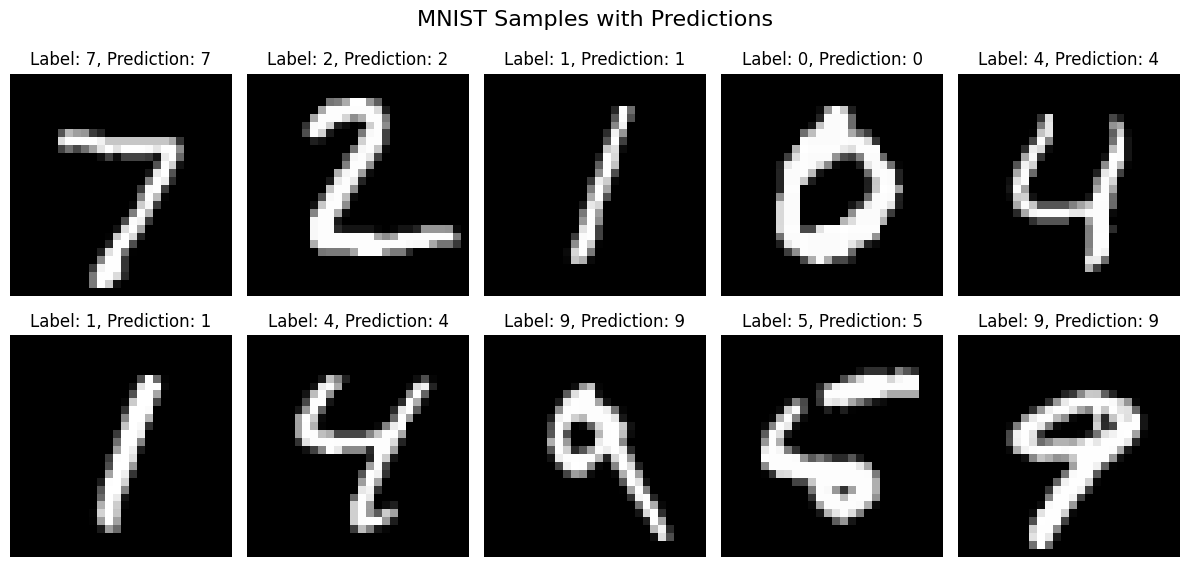

In [26]:
args = AllArguments()
args.load_model=True
args.batch_size=10
# args.n_workers=1
solver = Solver(args)
solver.plot_mnist_predictions()